In [1]:
from pandas_datareader import data as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from   scipy.io import loadmat
import time
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import StratifiedKFold, cross_val_score  # 导入交叉检验算法
from sklearn.feature_selection import SelectPercentile, f_classif  # 导入特征选择方法库
from sklearn.pipeline import Pipeline  # 导入Pipeline库
from sklearn.metrics import accuracy_score  # 准确率指标
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# from utility_funcs import *

import warnings
warnings.filterwarnings('ignore')


In [2]:
pre_neutralized_factors = pd.read_pickle('/home/ubuntu/data/factors.pkl')
neutralized_factors = pd.read_pickle('/home/ubuntu/data/neutralized_factors.pkl')
selected_factors = pd.read_pickle('/home/ubuntu/data/selected_factors.pkl')

feature_list = list(selected_factors.index)

print('Finish loading!')

Finish loading!


In [3]:
data = neutralized_factors[['code','day','sector','weekly_return'] + feature_list]
data

,code,day,sector,weekly_return,VOL60,VOL20,VOL5,VOL10,VOL120,ACD6,...,CFO2EV,TVSTD6,Volatility,JDQS20,DDNCR,TVMA20,MoneyFlow20,CTOP,HSIGMA,CCI5
0,4,20180105.0,28,-4.024702,-0.775176,-0.917950,-1.061420,-1.222159,-1.161016,0.764560,...,0.783831,-0.287749,-0.126651,1.940750,-0.199333,-0.268916,-0.268563,-0.397089,-0.441407,0.090599
1,600601,20180105.0,28,-1.355046,-1.246389,-1.201163,-1.220196,-1.228082,-1.201746,-0.507241,...,0.799740,-1.281351,-0.046834,-1.782799,0.605341,-1.400236,-1.399994,-0.217249,-1.758799,0.140573
2,600652,20180105.0,29,13.520729,-0.744055,-0.683546,-0.724665,-0.672548,-0.431911,-0.313788,...,0.002389,-0.900940,-0.865201,-0.269848,-0.297214,-0.631245,-0.631016,0.053134,0.010386,0.663940
3,600602,20180105.0,28,-0.277466,-1.286696,-1.117314,-1.102816,-1.186759,-1.254980,0.030110,...,0.503842,-0.909087,0.451541,-0.265318,-1.361486,-1.121716,-1.121395,0.481633,-0.360316,0.511521
4,600651,20180105.0,16,1.354170,0.663059,0.009371,-0.151267,0.070555,0.069727,0.066070,...,-0.361441,-0.680234,-1.052387,-0.905105,0.814633,-0.344706,-0.345137,0.192816,0.109807,0.292743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573404,300980,20211022.0,6,1.013339,0.478774,-0.493997,-0.906647,-0.926890,1.402471,-0.310812,...,-0.154294,0.435118,1.179695,1.747348,1.026139,0.563466,0.563503,-0.636685,-1.164114,0.013526
573405,605016,20211022.0,6,-1.184309,1.312164,1.556815,0.148629,1.489340,2.500906,-0.562508,...,-0.261223,0.612428,-0.194636,0.095345,1.555047,0.620462,0.620530,-0.673432,1.574468,-0.828693
573406,605098,20211022.0,15,5.422783,0.612101,1.335030,2.713900,2.722779,2.394376,2.049231,...,-0.754029,0.861121,1.551690,0.876572,1.450885,0.623359,0.623791,1.023333,0.898465,1.179519
573407,300975,20211022.0,26,0.603139,1.522815,-0.526855,0.577239,-0.075824,2.010993,0.096832,...,-1.011574,0.258743,0.180997,-0.751500,-0.537888,0.031673,0.032428,0.181428,-0.485219,0.870481


In [4]:
# 打标签，每个调仓日按照股票的周收益率排序，然后分成{n_label}组，每组为一类打标签，其中标签为1的收益最高，标签为12的收益最低。
n_label = 12
data['label'] = data.groupby('day').weekly_return.transform(lambda x: pd.qcut(x, n_label, labels=range(n_label-1, -1, -1)))
data

,code,day,sector,weekly_return,VOL60,VOL20,VOL5,VOL10,VOL120,ACD6,...,TVSTD6,Volatility,JDQS20,DDNCR,TVMA20,MoneyFlow20,CTOP,HSIGMA,CCI5,label
0,4,20180105.0,28,-4.024702,-0.775176,-0.917950,-1.061420,-1.222159,-1.161016,0.764560,...,-0.287749,-0.126651,1.940750,-0.199333,-0.268916,-0.268563,-0.397089,-0.441407,0.090599,10
1,600601,20180105.0,28,-1.355046,-1.246389,-1.201163,-1.220196,-1.228082,-1.201746,-0.507241,...,-1.281351,-0.046834,-1.782799,0.605341,-1.400236,-1.399994,-0.217249,-1.758799,0.140573,6
2,600652,20180105.0,29,13.520729,-0.744055,-0.683546,-0.724665,-0.672548,-0.431911,-0.313788,...,-0.900940,-0.865201,-0.269848,-0.297214,-0.631245,-0.631016,0.053134,0.010386,0.663940,0
3,600602,20180105.0,28,-0.277466,-1.286696,-1.117314,-1.102816,-1.186759,-1.254980,0.030110,...,-0.909087,0.451541,-0.265318,-1.361486,-1.121716,-1.121395,0.481633,-0.360316,0.511521,4
4,600651,20180105.0,16,1.354170,0.663059,0.009371,-0.151267,0.070555,0.069727,0.066070,...,-0.680234,-1.052387,-0.905105,0.814633,-0.344706,-0.345137,0.192816,0.109807,0.292743,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573404,300980,20211022.0,6,1.013339,0.478774,-0.493997,-0.906647,-0.926890,1.402471,-0.310812,...,0.435118,1.179695,1.747348,1.026139,0.563466,0.563503,-0.636685,-1.164114,0.013526,3
573405,605016,20211022.0,6,-1.184309,1.312164,1.556815,0.148629,1.489340,2.500906,-0.562508,...,0.612428,-0.194636,0.095345,1.555047,0.620462,0.620530,-0.673432,1.574468,-0.828693,4
573406,605098,20211022.0,15,5.422783,0.612101,1.335030,2.713900,2.722779,2.394376,2.049231,...,0.861121,1.551690,0.876572,1.450885,0.623359,0.623791,1.023333,0.898465,1.179519,1
573407,300975,20211022.0,26,0.603139,1.522815,-0.526855,0.577239,-0.075824,2.010993,0.096832,...,0.258743,0.180997,-0.751500,-0.537888,0.031673,0.032428,0.181428,-0.485219,0.870481,3


In [6]:
# 4/5 作为训练集，1/5作为测试集
train_data = data.iloc[:int(len(data)*0.8)]
test_data = data.iloc[int(len(data)*0.8):]
# 获取特征及标签
X_train = train_data[feature_list]
y_train = train_data['label']
X_test = test_data[feature_list]
y_test = test_data['label']
# 获取模型
xgb_model =  XGBClassifier(booster='gbtree', n_estimators=300, max_depth=3, subsample=0.9,
                           random_state=42 , objective ='multi:softprob', num_class = 12, 
                           tree_method='gpu_hist', eta=0.05)

In [25]:
# 模型训练
starttime = datetime.now()
print ('开始训练模型')
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, eval_metric=['merror', 'auc', 'mlogloss'], verbose=False)
endtime = datetime.now()
print ('模型运行时长：',int((endtime - starttime).seconds/60),'分钟')

开始训练模型
模型运行时长： 0 分钟


In [26]:
xgb_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_class=12, num_parallel_tree=None, ...)

In [84]:
# 保存训练好的模型
# xgb_model.save_model('/home/ubuntu/model/xgboost_v1_gpu.json') 

In [68]:
# 读取模型
# from xgboost import Booster
# clf = Booster(model_file='/home/ubuntu/model/xgboost_v1.json') 
# clf_gpu = Booster(model_file='/home/ubuntu/model/xgboost_v1_gpu.json') 

In [27]:
# evaluate train performance
yhat = xgb_model.get_booster().predict(xgb.DMatrix(X_train))
# xgb_model.get_booster().predict(xgb.DMatrix(X_train))
score = accuracy_score(y_train, yhat.argmax(1))
print('Accuracy: %.3f' % score)

Accuracy: 0.145


In [28]:
# evaluate test performance
# yhat_test = clf_gpu.predict(xgb.DMatrix(X_test))
yhat_test = xgb_model.get_booster().predict(xgb.DMatrix(X_test))
score_test = accuracy_score(y_test, yhat_test.argmax(1))
print('Accuracy: %.3f' % score_test)

Accuracy: 0.130


In [29]:
abs(yhat_test.argmax(1) - np.array(y_test)).mean()


3.7716380949059136

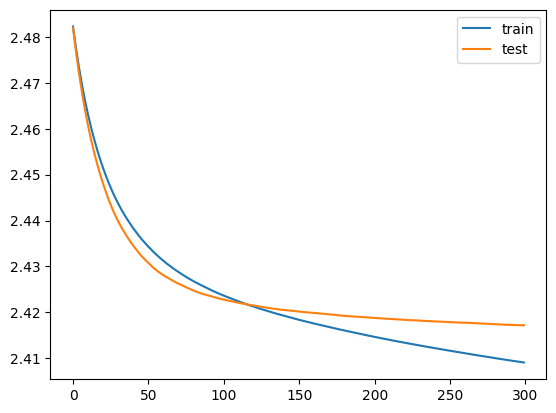

In [30]:
# retrieve performance metrics
# results = clf_gpu.evals_result()
plt.plot(xgb_model.evals_result()['validation_0']['mlogloss'], label='train')
plt.plot(xgb_model.evals_result()['validation_1']['mlogloss'], label='test')
plt.legend()
plt.show()


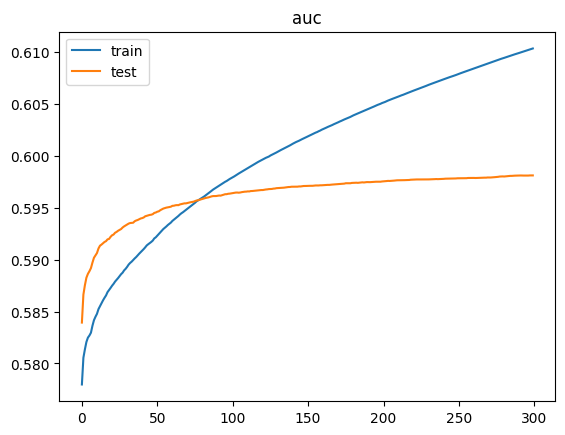

In [31]:
# ['merror', 'auc', 'mlogloss']
plt.plot(xgb_model.evals_result()['validation_0']['auc'], label='train')
plt.plot(xgb_model.evals_result()['validation_1']['auc'], label='test')
plt.title('auc')
plt.legend()
plt.show()
# xgb_model.evals_result()['validation_0'].keys()

<Axes: >

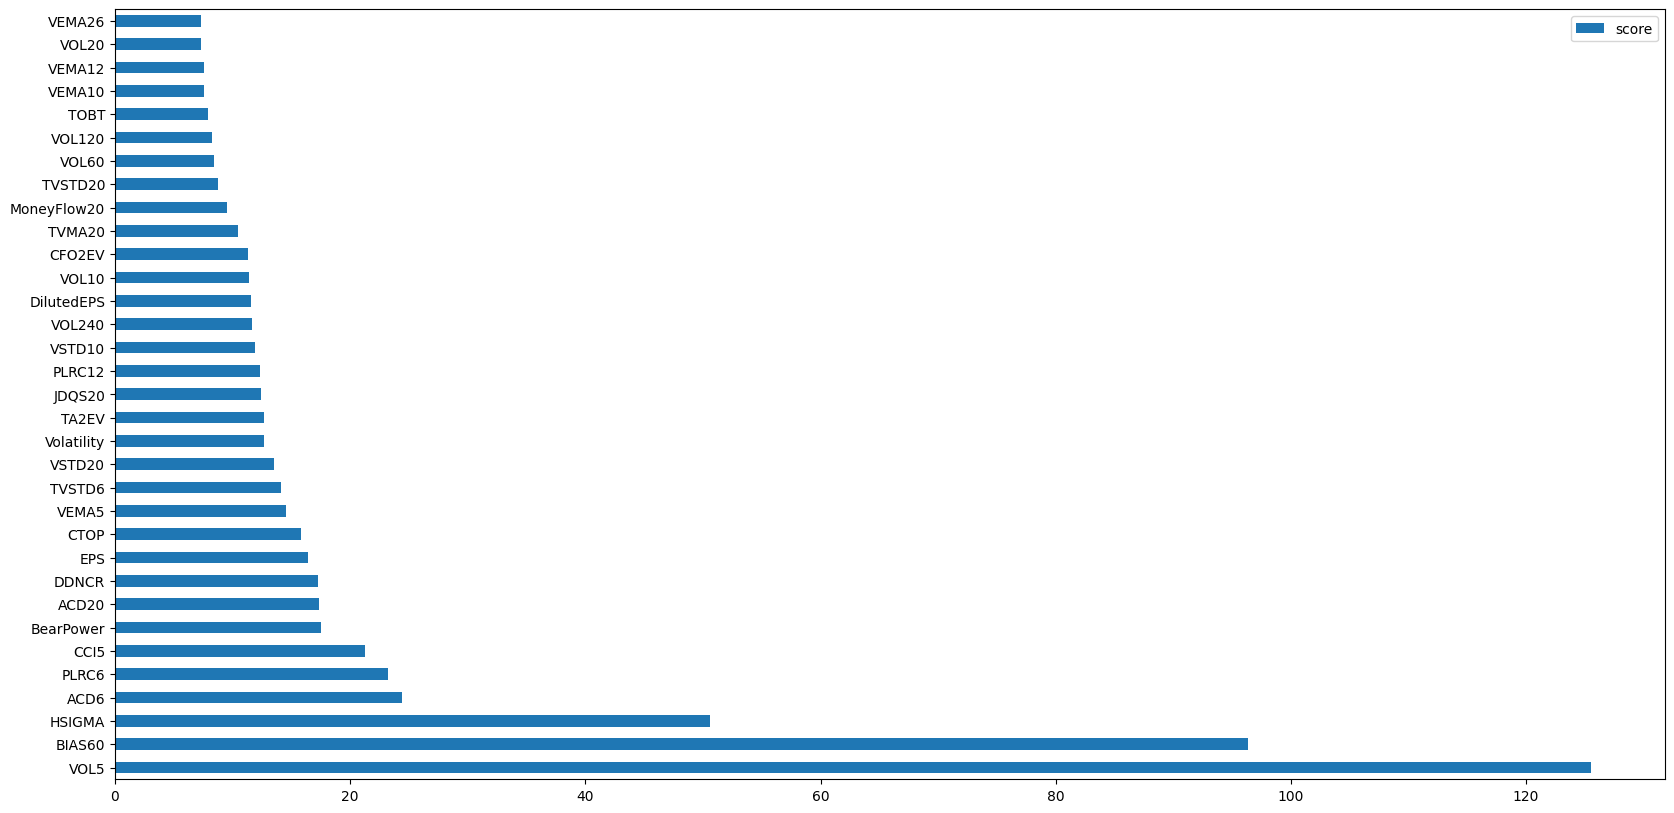

In [19]:
# 特征重要性
feature_important = xgb_model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

d = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
d.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [7]:
from sklearn.model_selection import GridSearchCV

params = { 'max_depth': [1,3,5],
           'eta': [0.01, 0.05, 0.1],
           'subsample': [0.8, 0.85, 0.9],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.5, 0.7, 0.9, 1],
           'objective': ['multi:softprob'],
           'tree_method': ['gpu_hist'],
           'random_state': [42],
           'num_class': [12]
           }

clf = GridSearchCV(estimator=xgb.XGBClassifier(), 
                   param_grid=params,
                   scoring='roc_auc', 
                   verbose=1)

eval_set = [(X_train, y_train), (X_test, y_test)]
clf.fit(X_train, y_train, eval_set=eval_set, eval_metric=['merror', 'auc', 'mlogloss'], verbose=False)

best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print("Best parameters:", clf.best_params_)
print("Lowest roc_auc: ", (-clf.best_score_)**(1/2.0))
print('Raw AUC score:', score)

for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [ ]:
clf.save_model('/home/ubuntu/model/grid_cv.json') 

### 策略部分

每周EOW交易一次，每次等权持有有效股票池中第一类（一周收益率最高的一类）预测概率最高的股票，要求预测的概率需大于0.5，每只股票的仓位是：1/持股总数。如果所有股票第一类的预测概率都不大于0.5，则空仓。

In [192]:
test_data

,code,day,sector,weekly_return,VOL60,VOL20,VOL5,VOL10,VOL120,ACD6,...,TVSTD6,Volatility,JDQS20,DDNCR,TVMA20,MoneyFlow20,CTOP,HSIGMA,CCI5,label
458727,300588,20210226.0,28,7.014680,-0.166624,-0.453745,-0.296233,-0.244678,2.212852,0.567543,...,0.261776,-1.733462,0.419968,-0.955908,0.655726,0.656432,-0.102067,0.583976,1.958572,1
458728,603035,20210226.0,13,4.086542,-0.208201,-0.330222,-0.637782,-0.342009,0.152024,0.114476,...,-0.320996,-0.602572,-1.371366,0.365398,-0.055249,-0.054971,1.007634,-0.046324,-0.331149,4
458729,2838,20210226.0,6,-2.378696,0.318808,-0.218187,-0.483593,-0.476062,-0.036020,0.167201,...,-0.719928,0.110831,-1.334567,-2.021552,-0.566161,-0.566866,0.536169,1.868589,0.491787,10
458730,603228,20210226.0,26,3.946459,-1.098036,-1.024061,-0.976244,-0.972639,-1.108704,0.626794,...,-1.819108,0.299261,0.030079,1.263304,-2.572620,-2.572843,-0.061485,-1.455614,2.084927,4
458731,603877,20210226.0,17,10.502958,-0.506637,-0.540252,-0.505228,-0.554988,-0.366875,1.543071,...,-1.054407,-0.073004,1.230868,-1.104623,-1.377928,-1.377963,0.205946,1.086508,0.562171,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573404,300980,20211022.0,6,1.013339,0.478774,-0.493997,-0.906647,-0.926890,1.402471,-0.310812,...,0.435118,1.179695,1.747348,1.026139,0.563466,0.563503,-0.636685,-1.164114,0.013526,3
573405,605016,20211022.0,6,-1.184309,1.312164,1.556815,0.148629,1.489340,2.500906,-0.562508,...,0.612428,-0.194636,0.095345,1.555047,0.620462,0.620530,-0.673432,1.574468,-0.828693,4
573406,605098,20211022.0,15,5.422783,0.612101,1.335030,2.713900,2.722779,2.394376,2.049231,...,0.861121,1.551690,0.876572,1.450885,0.623359,0.623791,1.023333,0.898465,1.179519,1
573407,300975,20211022.0,26,0.603139,1.522815,-0.526855,0.577239,-0.075824,2.010993,0.096832,...,0.258743,0.180997,-0.751500,-0.537888,0.031673,0.032428,0.181428,-0.485219,0.870481,3


In [221]:
initial_balance = 1000000 # 一百万初始资金
max_n_stock = 20

class warehouse:
    stocknum = 20
    stock_list = {}




array([11,  5,  6, ..., 11,  9,  1])

In [196]:
def get_stocks_to_buy():
    return
xgb_model.get_booster().predict(xgb.DMatrix(X_test)).argmax(1)
a=

In [220]:
# sum(a==0) / len(test_data.day.unique())
test_data['y_pred'] = xgb_model.get_booster().predict(xgb.DMatrix(X_test)).argmax(1)
test_data['y_prob'] = xgb_model.get_booster().predict(xgb.DMatrix(X_test)).max(1)
test_data

,code,day,sector,weekly_return,VOL60,VOL20,VOL5,VOL10,VOL120,ACD6,...,JDQS20,DDNCR,TVMA20,MoneyFlow20,CTOP,HSIGMA,CCI5,label,y_pred,y_prob
458727,300588,20210226.0,28,7.014680,-0.166624,-0.453745,-0.296233,-0.244678,2.212852,0.567543,...,0.419968,-0.955908,0.655726,0.656432,-0.102067,0.583976,1.958572,1,11,0.109255
458728,603035,20210226.0,13,4.086542,-0.208201,-0.330222,-0.637782,-0.342009,0.152024,0.114476,...,-1.371366,0.365398,-0.055249,-0.054971,1.007634,-0.046324,-0.331149,4,5,0.115047
458729,2838,20210226.0,6,-2.378696,0.318808,-0.218187,-0.483593,-0.476062,-0.036020,0.167201,...,-1.334567,-2.021552,-0.566161,-0.566866,0.536169,1.868589,0.491787,10,6,0.095378
458730,603228,20210226.0,26,3.946459,-1.098036,-1.024061,-0.976244,-0.972639,-1.108704,0.626794,...,0.030079,1.263304,-2.572620,-2.572843,-0.061485,-1.455614,2.084927,4,6,0.110732
458731,603877,20210226.0,17,10.502958,-0.506637,-0.540252,-0.505228,-0.554988,-0.366875,1.543071,...,1.230868,-1.104623,-1.377928,-1.377963,0.205946,1.086508,0.562171,0,11,0.145731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573404,300980,20211022.0,6,1.013339,0.478774,-0.493997,-0.906647,-0.926890,1.402471,-0.310812,...,1.747348,1.026139,0.563466,0.563503,-0.636685,-1.164114,0.013526,3,4,0.118859
573405,605016,20211022.0,6,-1.184309,1.312164,1.556815,0.148629,1.489340,2.500906,-0.562508,...,0.095345,1.555047,0.620462,0.620530,-0.673432,1.574468,-0.828693,4,0,0.097402
573406,605098,20211022.0,15,5.422783,0.612101,1.335030,2.713900,2.722779,2.394376,2.049231,...,0.876572,1.450885,0.623359,0.623791,1.023333,0.898465,1.179519,1,11,0.245489
573407,300975,20211022.0,26,0.603139,1.522815,-0.526855,0.577239,-0.075824,2.010993,0.096832,...,-0.751500,-0.537888,0.031673,0.032428,0.181428,-0.485219,0.870481,3,9,0.094700


In [241]:
# test_data[(test_data.y_pred==0)&(test_data.y_prob>0.1)].groupby('day').count()
test_data[(test_data.y_pred==0)].groupby('day').apply(lambda x: (x.sort_values('y_prob',ascending=False)[:20]))

code         day  sector  weekly_return     VOL60   
day                                                                      
20210226.0 459254  688202  20210226.0      30       0.071216  0.177446  \
           459081  603486  20210226.0      10      -3.346258  0.500356   
           459301  688026  20210226.0      30      12.097322  1.097285   
           458900  603801  20210226.0       9      13.286411 -0.173230   
           458795  300618  20210226.0       3     -11.393124  3.183585   
...                   ...         ...     ...            ...       ...   
20211022.0 572387  300573  20211022.0      18      16.934240  0.513046   
           573393  688315  20211022.0      30       5.434501  0.130182   
           572854  603185  20211022.0      11       7.654500  1.531570   
           570250  600779  20211022.0      19       3.574824  0.274638   
           570257  600782  20211022.0       5      -3.939265  0.467259   

                      VOL20      VOL5     VOL10    VOL120      ACD6  ...   
day                                                                  ...   
20210226.0 459254  0.152598 -0.034364  0.260946 -0.089777 -2.016481  ...  \
           459081  0.487565  0.654364  0.612860  0.494471 -2.016481  ...   
           459301  0.819576  0.015863  0.379457  0.189353  0.609859  ...   
           458900  0.319368  0.274238  0.357468 -0.288022 -2.016481  ...   
           458795  3.089304  3.052012  3.041587  2.087825 -1.899404  ...   
...                     ...       ...       ...       ...       ...  ...   
20211022.0 572387  0.936125  0.391218  0.758407  0.384531 -2.643052  ...   
           573393  0.538529  0.652656  0.762989  1.016318 -1.807491  ...   
           572854  1.503549  1.898205  1.837509  1.947184 -2.643052  ...   
           570250  0.295552  0.210909  0.421862  0.456565 -2.441615  ...   
           570257  0.730895  1.010850  0.819584  0.346892 -0.332611  ...   

                     JDQS20     DDNCR    TVMA20  MoneyFlow20      CTOP   
day                                                                      
20210226.0 459254 -0.590371  1.218110 -0.203550    -0.202149 -0.553102  \
           459081 -0.595757  1.529028  0.337542     0.339472 -0.946447   
           459301  1.260863 -1.368271  0.227933     0.225679  0.224154   
           458900 -0.641217  1.592453 -0.086815    -0.089445  0.233735   
           458795 -0.639939  0.211574  3.384570     3.385380 -0.763584   
...                     ...       ...       ...          ...       ...   
20211022.0 572387 -0.536881  2.308116  0.369392     0.372509 -0.328187   
           573393  0.256247  1.028759  0.365569     0.365891 -0.302235   
           572854  0.403341  1.823485  3.148732     3.148650 -0.784933   
           570250 -0.399773  1.444904  1.453198     1.448021 -0.418455   
           570257  1.360986 -1.365183  1.465430     1.471193  2.508885   

                     HSIGMA      CCI5  label  y_pred    y_prob  
day                                                             
20210226.0 459254  0.936197 -0.026401      8       0  0.211730  
           459081  0.990999 -1.109736     10       0  0.165819  
           459301  1.364415 -1.248123      0       0  0.164964  
           458900  1.117106 -0.516414      0       0  0.157064  
           458795  1.339471 -1.308524     11       0  0.156786  
...                     ...       ...    ...     ...       ...  
20211022.0 572387  1.635441 -0.649169      0       0  0.141082  
           573393  2.455757 -0.960820      1       0  0.140042  
           572854  1.925751 -0.860578      1       0  0.139388  
           570250  1.664698 -0.699858      2       0  0.138153  
           570257  1.284928 -1.333951      7       0  0.137876  

[700 rows x 40 columns]

In [4]:
transform = SelectPercentile(f_classif)  # 使用f_classif方法选择特征最明显的?%数量的特征

#model = RandomForestClassifier()
model = XGBClassifier()
# 建立由特征选择和分类模型构成的“管道”对象
model_pipe = Pipeline(steps=[('ANOVA', transform), ('model', model)])  

In [ ]:
# 选择最佳特征比例
# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
for percentile in percentiles:
    model_pipe.set_params(ANOVA__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(model_pipe, X_train, y_train, cv=5, n_jobs=-1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title('Performance of the model-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')
plt.axis('tight')
plt.show()
